Link do notatnika: https://colab.research.google.com/drive/18k7H_3N7uf-xQAnW9BEXldYImJqcPxFr?usp=sharing

---



<h1>ZMGSN Lista 3. - Normalizing Flows (NF)</h1>

<h2>Opis zadania</h2>

W ramach zadania należy:
<ol>
<li>Zapoznać się z poniższym eksperymentem z wykorzystaniem modelu NICE (ang. Non-linear Independent Components Estimation)</li>
<li>Dokonać analizy wpływu hiperparametrów eksperymentu, np. kroku uczenia, rozmiaru pakietu (ang. <i>batch size</i>), liczby epok na wyniki modelu NICE (25 pkt)</li>
<li>Dokonać modyfikacji architektury modelu NICE w celu zbadania wpływu architektury na wyniki (15 pkt)</li>
<li>Dokonać ewaluacji innych wariantów sieci opartych o przepływy normalizacyjne, np. ConvFlow, MAF, IAF itp. (30 pkt)</li>
<li>Opracować procedurę ewaluacji jakości działania modelu NICE i innych rozważanych wariantów, uwzględniającą różne metody wizualizacji (np. wykresy, miary, klasy), klasteryzacji, redukcji wymiarów (np. t-SNE) (30 pkt)</li>
</ol>

Ocenie podlegać będzie jakość wykonania zadania, w tym:
<ol>
<li>Właściwe wykonanie zadań</li>
<li>Rzetelne opracowanie wyników, uwzględniające analizę jakościową i ilościową</li>
<li>Opracowanie wniosków mających na celu wyjaśnienie badanych zjawisk i uzyskanych wyników</li>
<li>Opracowanie i wyjaśnienie kodu źródłowego</li>
</ol>


<h2>Import używanych bibliotek</h2>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision
import plotly.express as px
import pandas as pd

from keras.datasets.mnist import load_data
from tqdm import tqdm
from torch.distributions.transformed_distribution import TransformedDistribution
from torch.distributions.uniform import Uniform
from torch.distributions.transforms import SigmoidTransform
from torch.distributions.transforms import AffineTransform
from torch.utils.data import DataLoader

from tqdm.notebook import tqdm

##Dane

<h2>Inicjalizacja ziarna generatora liczb pseudolosowych</h2>

In [ ]:
torch.manual_seed(0)

<h2>Określenie domyślnego urządzenia na podstawie sprawdzenia dostępności karty graficznej</h2>

In [ ]:
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

Using device cuda:0


<h2>Pobranie, rozpakowanie i normalizacja zbioru danych</h2>

In [ ]:
(trainX, trainY), (testX, testy) = load_data()
trainX = (np.float32(trainX) + torch.rand(trainX.shape).numpy()) / 255.
trainX = trainX.clip(0, 1)
trainX = torch.tensor(trainX.reshape(-1, 28 * 28))

11490434/11490434 [==============================] - 0s 0us/step


##<h2>Deklaracja podstawowej klasy modelu NICE (ang. Non-linear Independent Component Estimation)<h2>

In [ ]:
class NICE(nn.Module):

    def __init__(self, data_dim=28 * 28, hidden_dim=1000):
        super().__init__()

        self.m = torch.nn.ModuleList([nn.Sequential(
            nn.Linear(data_dim // 2, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, data_dim // 2), ) for i in range(4)])
        self.s = torch.nn.Parameter(torch.randn(data_dim))

    def forward(self, x):
        x = x.clone()
        for i in range(len(self.m)):
            x_i1 = x[:, ::2] if (i % 2) == 0 else x[:, 1::2]
            x_i2 = x[:, 1::2] if (i % 2) == 0 else x[:, ::2]
            h_i1 = x_i1
            h_i2 = x_i2 + self.m[i](x_i1)
            x = torch.empty(x.shape, device=x.device)
            x[:, ::2] = h_i1
            x[:, 1::2] = h_i2
        z = torch.exp(self.s) * x
        log_jacobian = torch.sum(self.s)
        return z, log_jacobian

    def invert(self, z):
        x = z.clone() / torch.exp(self.s)
        for i in range(len(self.m) - 1, -1, -1):
            h_i1 = x[:, ::2]
            h_i2 = x[:, 1::2]
            x_i1 = h_i1
            x_i2 = h_i2 - self.m[i](x_i1)
            x = torch.empty(x.shape, device=x.device)
            x[:, ::2] = x_i1 if (i % 2) == 0 else x_i2
            x[:, 1::2] = x_i2 if (i % 2) == 0 else x_i1
        return x

<h2>Definicja klasy reprezentującej standardowy rozkład logistyczny</h2>

In [ ]:
class StandardLogisticDistribution:

    def __init__(self, data_dim=28 * 28, device='cpu'):
        self.m = TransformedDistribution(
            Uniform(torch.zeros(data_dim, device=device),
                    torch.ones(data_dim, device=device)),
            [SigmoidTransform().inv, AffineTransform(torch.zeros(data_dim, device=device),
                                                     torch.ones(data_dim, device=device))]
        )

    def log_pdf(self, z):
        return self.m.log_prob(z).sum(dim=1)

    def sample(self):
        return self.m.sample()

<h2>Przykładowa pętla ucząca</h2>

In [ ]:
def training(normalizing_flow, optimizer, dataloader, distribution, epochs=1500, device='cpu'):
    training_loss = []
    for epoch in tqdm(range(epochs)):
        loss_list = []
        for batch in dataloader:
            z, log_jacobian = normalizing_flow(batch.to(device))
            log_likelihood = distribution.log_pdf(z) + log_jacobian
            loss = -log_likelihood.sum()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_list.append(loss.item())
        training_loss.append(loss.item())

        print(f"Epoch [{epoch+1}/{epochs}], avg_loss: {np.mean(loss_list):.4f}")

    return training_loss

In [ ]:
def plot_res():
    nb_data = 6
    fig, axs = plt.subplots(nb_data, nb_data, figsize=(4, 4))
    for i in range(nb_data):
        for j in range(nb_data):
            x = normalizing_flow.invert(logistic_distribution.sample().unsqueeze(0)).data.cpu().numpy()
            axs[i, j].imshow(x.reshape(28, 28).clip(0, 1), cmap='gray')
            axs[i, j].set_xticks([])
            axs[i, j].set_yticks([])
    plt.show()

<h2>Inicjalizacja sieci NICE i uruchomienie procesu uczenia</h2>

#Eksperymenty

In [ ]:
normalizing_flow = NICE().to(device)
logistic_distribution = StandardLogisticDistribution(device=device)
x = torch.randn(10, 28 * 28, device=device)

optimizer = torch.optim.Adam(normalizing_flow.parameters(), lr=0.0002, weight_decay=0.9)
dataloader = DataLoader(trainX, batch_size=32, shuffle=True)

training_loss = training(normalizing_flow, optimizer, dataloader, logistic_distribution, epochs=15,
                         device=device)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [1/15], avg_loss: 31850.5023
Epoch [2/15], avg_loss: 22862.5051
Epoch [3/15], avg_loss: 14400.2839
Epoch [4/15], avg_loss: 6338.3124
Epoch [5/15], avg_loss: -1292.4279
Epoch [6/15], avg_loss: -8458.7607
Epoch [7/15], avg_loss: -15095.7423
Epoch [8/15], avg_loss: -21189.8996
Epoch [9/15], avg_loss: -26746.8453
Epoch [10/15], avg_loss: -31800.7856
Epoch [11/15], avg_loss: -36402.7353
Epoch [12/15], avg_loss: -40557.8679
Epoch [13/15], avg_loss: -44289.1571
Epoch [14/15], avg_loss: -47602.7152
Epoch [15/15], avg_loss: -50492.5729


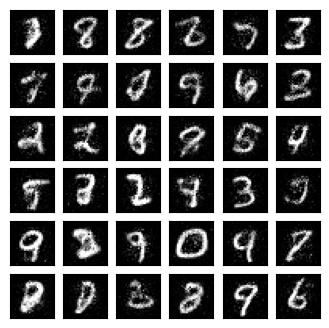

In [ ]:
plot_res()

##B_S

###Batch size: 16

In [ ]:
normalizing_flow = NICE().to(device)
logistic_distribution = StandardLogisticDistribution(device=device)
x = torch.randn(10, 28 * 28, device=device)

optimizer = torch.optim.Adam(normalizing_flow.parameters(), lr=0.0002, weight_decay=0.9)
dataloader = DataLoader(trainX, batch_size=16, shuffle=True)

training_loss_bs_16 = training(normalizing_flow, optimizer, dataloader, logistic_distribution, epochs=15,
                         device=device)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [1/15], avg_loss: 13910.6127
Epoch [2/15], avg_loss: 5687.4720
Epoch [3/15], avg_loss: -1554.8543
Epoch [4/15], avg_loss: -7660.2503
Epoch [5/15], avg_loss: -12731.6592
Epoch [6/15], avg_loss: -16897.3315
Epoch [7/15], avg_loss: -20236.9535
Epoch [8/15], avg_loss: -22854.1500
Epoch [9/15], avg_loss: -24778.2818
Epoch [10/15], avg_loss: -26081.1450
Epoch [11/15], avg_loss: -26884.1270
Epoch [12/15], avg_loss: -27408.1631
Epoch [13/15], avg_loss: -27767.5157
Epoch [14/15], avg_loss: -28052.2684
Epoch [15/15], avg_loss: -28281.7445


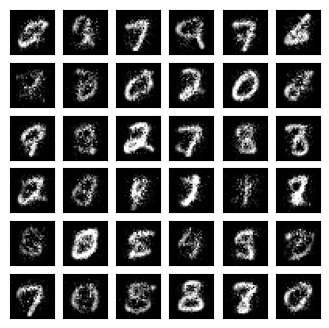

In [ ]:
plot_res()

### Batch size: 64

In [ ]:
normalizing_flow = NICE().to(device)
logistic_distribution = StandardLogisticDistribution(device=device)
x = torch.randn(10, 28 * 28, device=device)

optimizer = torch.optim.Adam(normalizing_flow.parameters(), lr=0.0002, weight_decay=0.9)
dataloader = DataLoader(trainX, batch_size=64, shuffle=True)

training_loss_bs_64 = training(normalizing_flow, optimizer, dataloader, logistic_distribution, epochs=15,
                         device=device)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [1/15], avg_loss: 66063.3125
Epoch [2/15], avg_loss: 56387.2005
Epoch [3/15], avg_loss: 47266.4899
Epoch [4/15], avg_loss: 38321.2124
Epoch [5/15], avg_loss: 29563.2881
Epoch [6/15], avg_loss: 20960.5153
Epoch [7/15], avg_loss: 12551.3258
Epoch [8/15], avg_loss: 4344.8628
Epoch [9/15], avg_loss: -3636.4883
Epoch [10/15], avg_loss: -11386.0094
Epoch [11/15], avg_loss: -18906.7158
Epoch [12/15], avg_loss: -26185.6278
Epoch [13/15], avg_loss: -33212.7341
Epoch [14/15], avg_loss: -39969.0169
Epoch [15/15], avg_loss: -46451.8277


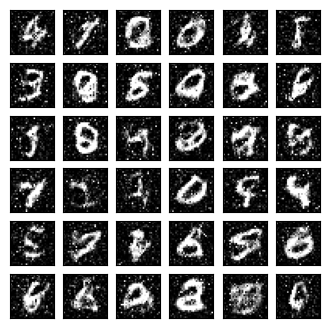

In [ ]:
plot_res()

###Summary

In [ ]:
y_values = {
    '16': training_loss_bs_16,
    '32': training_loss,
    '64': training_loss_bs_64
}
df = pd.DataFrame(y_values)

fig = px.line(df, labels={'value': 'Loss', 'index': 'Epoch'},
              title='Batch Sizes')

fig.show()

##L_r:

###L_r: 0.001

In [ ]:
normalizing_flow = NICE().to(device)
logistic_distribution = StandardLogisticDistribution(device=device)
x = torch.randn(10, 28 * 28, device=device)

optimizer = torch.optim.Adam(normalizing_flow.parameters(), lr=0.001, weight_decay=0.9)
dataloader = DataLoader(trainX, batch_size=32, shuffle=True)

training_loss_lr_001 = training(normalizing_flow, optimizer, dataloader, logistic_distribution, epochs=15,
                         device=device)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [1/15], avg_loss: 14292.6089
Epoch [2/15], avg_loss: -18331.3277
Epoch [3/15], avg_loss: -38424.5462
Epoch [4/15], avg_loss: -49165.5528
Epoch [5/15], avg_loss: -53400.4408
Epoch [6/15], avg_loss: -54892.7174
Epoch [7/15], avg_loss: -55659.8145
Epoch [8/15], avg_loss: -56136.8962
Epoch [9/15], avg_loss: -56475.2198
Epoch [10/15], avg_loss: -56779.0619
Epoch [11/15], avg_loss: -57023.6195
Epoch [12/15], avg_loss: -57232.0548
Epoch [13/15], avg_loss: -57400.6947
Epoch [14/15], avg_loss: -57579.6866
Epoch [15/15], avg_loss: -57710.8684


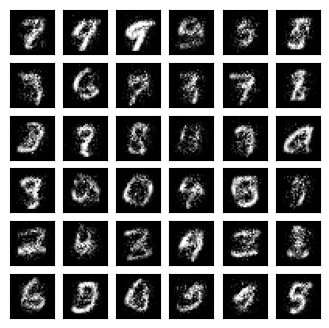

In [ ]:
plot_res()

###L_r: 0.00005

In [ ]:
normalizing_flow = NICE().to(device)
logistic_distribution = StandardLogisticDistribution(device=device)
x = torch.randn(10, 28 * 28, device=device)

optimizer = torch.optim.Adam(normalizing_flow.parameters(), lr=0.00005, weight_decay=0.9)
dataloader = DataLoader(trainX, batch_size=32, shuffle=True)

training_loss_lr_00005 = training(normalizing_flow, optimizer, dataloader, logistic_distribution, epochs=15,
                         device=device)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [1/15], avg_loss: 35006.3725
Epoch [2/15], avg_loss: 32380.9627
Epoch [3/15], avg_loss: 30046.5852
Epoch [4/15], avg_loss: 27758.2312
Epoch [5/15], avg_loss: 25496.3462
Epoch [6/15], avg_loss: 23257.6307
Epoch [7/15], avg_loss: 21041.1815
Epoch [8/15], avg_loss: 18842.7004
Epoch [9/15], avg_loss: 16669.6654
Epoch [10/15], avg_loss: 14521.4130
Epoch [11/15], avg_loss: 12396.9654
Epoch [12/15], avg_loss: 10300.7923
Epoch [13/15], avg_loss: 8233.2251
Epoch [14/15], avg_loss: 6195.7368
Epoch [15/15], avg_loss: 4183.1095


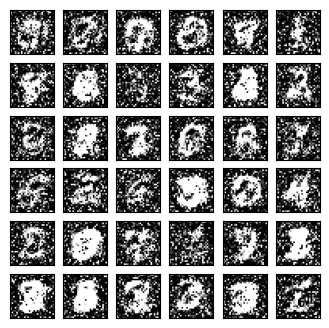

In [ ]:
plot_res()

###Summary

In [ ]:
y_values = {
    '0.001': training_loss_lr_001,
    '0.0002': training_loss,
    '0.00005': training_loss_lr_00005
}
df = pd.DataFrame(y_values)

fig = px.line(df, labels={'value': 'Loss', 'index': 'Epoch'},
              title='Learning Rates')

fig.show()

##Epochs

### Default 15 epochs

In [ ]:
normalizing_flow = NICE().to(device)
logistic_distribution = StandardLogisticDistribution(device=device)
x = torch.randn(10, 28 * 28, device=device)

optimizer = torch.optim.Adam(normalizing_flow.parameters(), lr=0.0002, weight_decay=0.9)
dataloader = DataLoader(trainX, batch_size=32, shuffle=True)

training_loss = training(normalizing_flow, optimizer, dataloader, logistic_distribution, epochs=15,
                         device=device)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [1/15], avg_loss: 31708.5461
Epoch [2/15], avg_loss: 22729.8120
Epoch [3/15], avg_loss: 14237.8087
Epoch [4/15], avg_loss: 6161.7789
Epoch [5/15], avg_loss: -1492.8619
Epoch [6/15], avg_loss: -8688.0785
Epoch [7/15], avg_loss: -15422.8820
Epoch [8/15], avg_loss: -21633.9306
Epoch [9/15], avg_loss: -27337.7911
Epoch [10/15], avg_loss: -32540.4775
Epoch [11/15], avg_loss: -37227.7797
Epoch [12/15], avg_loss: -41426.2999
Epoch [13/15], avg_loss: -45181.2824
Epoch [14/15], avg_loss: -48487.1287
Epoch [15/15], avg_loss: -51377.5311


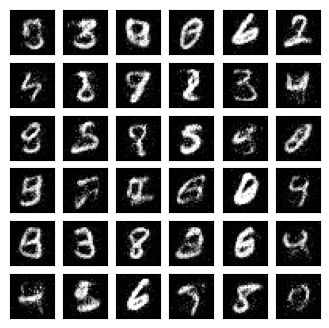

In [ ]:
plot_res()

### 10 epochs

In [ ]:
normalizing_flow = NICE().to(device)
logistic_distribution = StandardLogisticDistribution(device=device)
x = torch.randn(10, 28 * 28, device=device)

optimizer = torch.optim.Adam(normalizing_flow.parameters(), lr=0.0002, weight_decay=0.9)
dataloader = DataLoader(trainX, batch_size=32, shuffle=True)

training_loss_500 = training(normalizing_flow, optimizer, dataloader, logistic_distribution, epochs=10,
                         device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1/10], avg_loss: 30211.9864
Epoch [2/10], avg_loss: 21237.1010
Epoch [3/10], avg_loss: 12732.7087
Epoch [4/10], avg_loss: 4652.5730
Epoch [5/10], avg_loss: -2977.0487
Epoch [6/10], avg_loss: -10132.4474
Epoch [7/10], avg_loss: -16748.7231
Epoch [8/10], avg_loss: -22822.7103
Epoch [9/10], avg_loss: -28391.3935
Epoch [10/10], avg_loss: -33418.4209


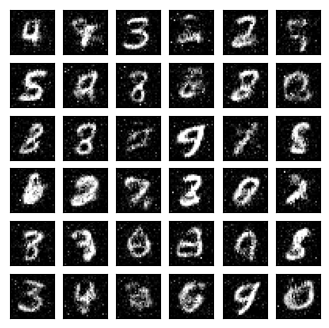

In [ ]:
plot_res()

### 30 epochs

In [ ]:
normalizing_flow = NICE().to(device)
logistic_distribution = StandardLogisticDistribution(device=device)
x = torch.randn(10, 28 * 28, device=device)

optimizer = torch.optim.Adam(normalizing_flow.parameters(), lr=0.0002, weight_decay=0.9)
dataloader = DataLoader(trainX, batch_size=32, shuffle=True)

training_loss_30 = training(normalizing_flow, optimizer, dataloader, logistic_distribution, epochs=30,
                         device=device)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [1/30], avg_loss: 30852.8631
Epoch [2/30], avg_loss: 21867.8923
Epoch [3/30], avg_loss: 13388.4604
Epoch [4/30], avg_loss: 5327.3770
Epoch [5/30], avg_loss: -2313.2709
Epoch [6/30], avg_loss: -9452.5921
Epoch [7/30], avg_loss: -16089.9649
Epoch [8/30], avg_loss: -22202.9563
Epoch [9/30], avg_loss: -27770.6530
Epoch [10/30], avg_loss: -32836.7669
Epoch [11/30], avg_loss: -37416.3718
Epoch [12/30], avg_loss: -41481.3849
Epoch [13/30], avg_loss: -45067.1475
Epoch [14/30], avg_loss: -48192.0699
Epoch [15/30], avg_loss: -50899.1061
Epoch [16/30], avg_loss: -53242.1640
Epoch [17/30], avg_loss: -55204.2088
Epoch [18/30], avg_loss: -56827.8300
Epoch [19/30], avg_loss: -58096.5905
Epoch [20/30], avg_loss: -59113.7394
Epoch [21/30], avg_loss: -59890.0853
Epoch [22/30], avg_loss: -60497.8118
Epoch [23/30], avg_loss: -60977.8956
Epoch [24/30], avg_loss: -61393.2906
Epoch [25/30], avg_loss: -61747.0194
Epoch [26/30], avg_loss: -62048.9766
Epoch [27/30], avg_loss: -62352.9972
Epoch [28/30], av

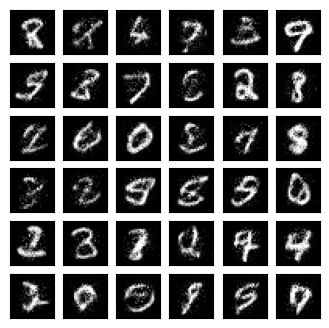

In [ ]:
plot_res()

#Inna architektura

##hidden_dim=700

In [ ]:
class NICE(nn.Module):

    def __init__(self, data_dim=28 * 28, hidden_dim=700):
        super().__init__()

        self.m = torch.nn.ModuleList([nn.Sequential(
            nn.Linear(data_dim // 2, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, data_dim // 2), ) for i in range(4)])
        self.s = torch.nn.Parameter(torch.randn(data_dim))

    def forward(self, x):
        x = x.clone()
        for i in range(len(self.m)):
            x_i1 = x[:, ::2] if (i % 2) == 0 else x[:, 1::2]
            x_i2 = x[:, 1::2] if (i % 2) == 0 else x[:, ::2]
            h_i1 = x_i1
            h_i2 = x_i2 + self.m[i](x_i1)
            x = torch.empty(x.shape, device=x.device)
            x[:, ::2] = h_i1
            x[:, 1::2] = h_i2
        z = torch.exp(self.s) * x
        log_jacobian = torch.sum(self.s)
        return z, log_jacobian

    def invert(self, z):
        x = z.clone() / torch.exp(self.s)
        for i in range(len(self.m) - 1, -1, -1):
            h_i1 = x[:, ::2]
            h_i2 = x[:, 1::2]
            x_i1 = h_i1
            x_i2 = h_i2 - self.m[i](x_i1)
            x = torch.empty(x.shape, device=x.device)
            x[:, ::2] = x_i1 if (i % 2) == 0 else x_i2
            x[:, 1::2] = x_i2 if (i % 2) == 0 else x_i1
        return x

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [1/15], avg_loss: 30895.5671
Epoch [2/15], avg_loss: 21879.3320
Epoch [3/15], avg_loss: 13417.2972
Epoch [4/15], avg_loss: 5417.0952
Epoch [5/15], avg_loss: -2117.0645
Epoch [6/15], avg_loss: -9184.4486
Epoch [7/15], avg_loss: -15748.3287
Epoch [8/15], avg_loss: -21781.6312
Epoch [9/15], avg_loss: -27308.5417
Epoch [10/15], avg_loss: -32370.5354
Epoch [11/15], avg_loss: -36962.3314
Epoch [12/15], avg_loss: -41123.2140
Epoch [13/15], avg_loss: -44842.6775
Epoch [14/15], avg_loss: -48130.9599
Epoch [15/15], avg_loss: -51001.1399


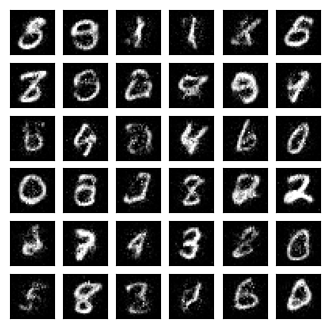

In [ ]:
normalizing_flow = NICE().to(device)
logistic_distribution = StandardLogisticDistribution(device=device)
x = torch.randn(10, 28 * 28, device=device)

optimizer = torch.optim.Adam(normalizing_flow.parameters(), lr=0.0002, weight_decay=0.9)
dataloader = DataLoader(trainX, batch_size=32, shuffle=True)

training_loss_hd_700 = training(normalizing_flow, optimizer, dataloader, logistic_distribution, epochs=15,
                         device=device)

plot_res()

##hidden_dim=1300

In [ ]:
class NICE(nn.Module):

    def __init__(self, data_dim=28 * 28, hidden_dim=1300):
        super().__init__()

        self.m = torch.nn.ModuleList([nn.Sequential(
            nn.Linear(data_dim // 2, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, data_dim // 2), ) for i in range(4)])
        self.s = torch.nn.Parameter(torch.randn(data_dim))

    def forward(self, x):
        x = x.clone()
        for i in range(len(self.m)):
            x_i1 = x[:, ::2] if (i % 2) == 0 else x[:, 1::2]
            x_i2 = x[:, 1::2] if (i % 2) == 0 else x[:, ::2]
            h_i1 = x_i1
            h_i2 = x_i2 + self.m[i](x_i1)
            x = torch.empty(x.shape, device=x.device)
            x[:, ::2] = h_i1
            x[:, 1::2] = h_i2
        z = torch.exp(self.s) * x
        log_jacobian = torch.sum(self.s)
        return z, log_jacobian

    def invert(self, z):
        x = z.clone() / torch.exp(self.s)
        for i in range(len(self.m) - 1, -1, -1):
            h_i1 = x[:, ::2]
            h_i2 = x[:, 1::2]
            x_i1 = h_i1
            x_i2 = h_i2 - self.m[i](x_i1)
            x = torch.empty(x.shape, device=x.device)
            x[:, ::2] = x_i1 if (i % 2) == 0 else x_i2
            x[:, 1::2] = x_i2 if (i % 2) == 0 else x_i1
        return x

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [1/15], avg_loss: 30335.6807
Epoch [2/15], avg_loss: 21397.0794
Epoch [3/15], avg_loss: 12984.1661
Epoch [4/15], avg_loss: 5006.8345
Epoch [5/15], avg_loss: -2496.7317
Epoch [6/15], avg_loss: -9562.4386
Epoch [7/15], avg_loss: -16169.9656
Epoch [8/15], avg_loss: -22254.2699
Epoch [9/15], avg_loss: -27804.2311
Epoch [10/15], avg_loss: -32838.2703
Epoch [11/15], avg_loss: -37394.1339
Epoch [12/15], avg_loss: -41513.8759
Epoch [13/15], avg_loss: -45192.2269
Epoch [14/15], avg_loss: -48452.1292
Epoch [15/15], avg_loss: -51293.2568


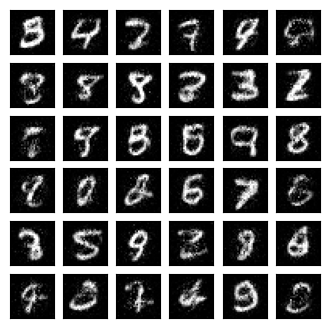

In [ ]:
normalizing_flow = NICE().to(device)
logistic_distribution = StandardLogisticDistribution(device=device)
x = torch.randn(10, 28 * 28, device=device)

optimizer = torch.optim.Adam(normalizing_flow.parameters(), lr=0.0002, weight_decay=0.9)
dataloader = DataLoader(trainX, batch_size=32, shuffle=True)

training_loss_hd_1300 = training(normalizing_flow, optimizer, dataloader, logistic_distribution, epochs=15,
                         device=device)

plot_res()

##Base

In [ ]:
class NICE(nn.Module):

    def __init__(self, data_dim=28 * 28, hidden_dim=1000):
        super().__init__()

        self.m = torch.nn.ModuleList([nn.Sequential(
            nn.Linear(data_dim // 2, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, data_dim // 2), ) for i in range(4)])
        self.s = torch.nn.Parameter(torch.randn(data_dim))

    def forward(self, x):
        x = x.clone()
        for i in range(len(self.m)):
            x_i1 = x[:, ::2] if (i % 2) == 0 else x[:, 1::2]
            x_i2 = x[:, 1::2] if (i % 2) == 0 else x[:, ::2]
            h_i1 = x_i1
            h_i2 = x_i2 + self.m[i](x_i1)
            x = torch.empty(x.shape, device=x.device)
            x[:, ::2] = h_i1
            x[:, 1::2] = h_i2
        z = torch.exp(self.s) * x
        log_jacobian = torch.sum(self.s)
        return z, log_jacobian

    def invert(self, z):
        x = z.clone() / torch.exp(self.s)
        for i in range(len(self.m) - 1, -1, -1):
            h_i1 = x[:, ::2]
            h_i2 = x[:, 1::2]
            x_i1 = h_i1
            x_i2 = h_i2 - self.m[i](x_i1)
            x = torch.empty(x.shape, device=x.device)
            x[:, ::2] = x_i1 if (i % 2) == 0 else x_i2
            x[:, 1::2] = x_i2 if (i % 2) == 0 else x_i1
        return x

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [1/15], avg_loss: 31826.1013
Epoch [2/15], avg_loss: 22861.5800
Epoch [3/15], avg_loss: 14379.5254
Epoch [4/15], avg_loss: 6291.4455
Epoch [5/15], avg_loss: -1347.0045
Epoch [6/15], avg_loss: -8524.0570
Epoch [7/15], avg_loss: -15175.5887
Epoch [8/15], avg_loss: -21298.4959
Epoch [9/15], avg_loss: -26900.6592
Epoch [10/15], avg_loss: -31994.8112
Epoch [11/15], avg_loss: -36630.3440
Epoch [12/15], avg_loss: -40806.9406
Epoch [13/15], avg_loss: -44519.7083
Epoch [14/15], avg_loss: -47814.7138
Epoch [15/15], avg_loss: -50676.8809


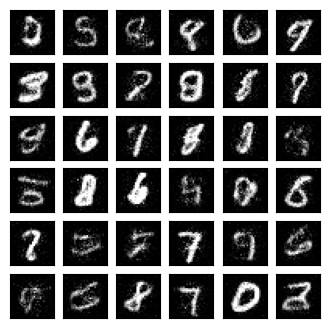

In [ ]:
normalizing_flow = NICE().to(device)
logistic_distribution = StandardLogisticDistribution(device=device)
x = torch.randn(10, 28 * 28, device=device)

optimizer = torch.optim.Adam(normalizing_flow.parameters(), lr=0.0002, weight_decay=0.9)
dataloader = DataLoader(trainX, batch_size=32, shuffle=True)

training_loss_base = training(normalizing_flow, optimizer, dataloader, logistic_distribution, epochs=15,
                         device=device)

plot_res()

##Smaller

In [ ]:
class NICE(nn.Module):

    def __init__(self, data_dim=28 * 28, hidden_dim=1000):
        super().__init__()

        self.m = torch.nn.ModuleList([nn.Sequential(
            nn.Linear(data_dim // 2, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, data_dim // 2), ) for i in range(4)])
        self.s = torch.nn.Parameter(torch.randn(data_dim))

    def forward(self, x):
        x = x.clone()
        for i in range(len(self.m)):
            x_i1 = x[:, ::2] if (i % 2) == 0 else x[:, 1::2]
            x_i2 = x[:, 1::2] if (i % 2) == 0 else x[:, ::2]
            h_i1 = x_i1
            h_i2 = x_i2 + self.m[i](x_i1)
            x = torch.empty(x.shape, device=x.device)
            x[:, ::2] = h_i1
            x[:, 1::2] = h_i2
        z = torch.exp(self.s) * x
        log_jacobian = torch.sum(self.s)
        return z, log_jacobian

    def invert(self, z):
        x = z.clone() / torch.exp(self.s)
        for i in range(len(self.m) - 1, -1, -1):
            h_i1 = x[:, ::2]
            h_i2 = x[:, 1::2]
            x_i1 = h_i1
            x_i2 = h_i2 - self.m[i](x_i1)
            x = torch.empty(x.shape, device=x.device)
            x[:, ::2] = x_i1 if (i % 2) == 0 else x_i2
            x[:, 1::2] = x_i2 if (i % 2) == 0 else x_i1
        return x

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [1/15], avg_loss: 30781.8523
Epoch [2/15], avg_loss: 21599.5128
Epoch [3/15], avg_loss: 12793.9825
Epoch [4/15], avg_loss: 4348.1041
Epoch [5/15], avg_loss: -3625.0083
Epoch [6/15], avg_loss: -11027.1409
Epoch [7/15], avg_loss: -17837.5072
Epoch [8/15], avg_loss: -24044.6628
Epoch [9/15], avg_loss: -29658.7369
Epoch [10/15], avg_loss: -34705.5397
Epoch [11/15], avg_loss: -39208.3751
Epoch [12/15], avg_loss: -43216.8179
Epoch [13/15], avg_loss: -46772.0594
Epoch [14/15], avg_loss: -49885.8322
Epoch [15/15], avg_loss: -52575.1355


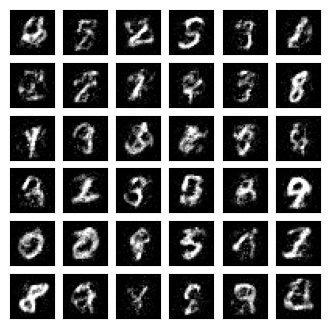

In [ ]:
normalizing_flow = NICE().to(device)
logistic_distribution = StandardLogisticDistribution(device=device)
x = torch.randn(10, 28 * 28, device=device)

optimizer = torch.optim.Adam(normalizing_flow.parameters(), lr=0.0002, weight_decay=0.9)
dataloader = DataLoader(trainX, batch_size=32, shuffle=True)

training_loss_sm = training(normalizing_flow, optimizer, dataloader, logistic_distribution, epochs=15,
                         device=device)

plot_res()

##Bigger

In [ ]:
class NICE(nn.Module):

    def __init__(self, data_dim=28 * 28, hidden_dim=1000):
        super().__init__()

        self.m = torch.nn.ModuleList([nn.Sequential(
            nn.Linear(data_dim // 2, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, data_dim // 2), ) for i in range(4)])
        self.s = torch.nn.Parameter(torch.randn(data_dim))

    def forward(self, x):
        x = x.clone()
        for i in range(len(self.m)):
            x_i1 = x[:, ::2] if (i % 2) == 0 else x[:, 1::2]
            x_i2 = x[:, 1::2] if (i % 2) == 0 else x[:, ::2]
            h_i1 = x_i1
            h_i2 = x_i2 + self.m[i](x_i1)
            x = torch.empty(x.shape, device=x.device)
            x[:, ::2] = h_i1
            x[:, 1::2] = h_i2
        print(self.s.shape, x.shape)

        z = torch.exp(self.s) * x
        log_jacobian = torch.sum(self.s)
        return z, log_jacobian

    def invert(self, z):
        x = z.clone() / torch.exp(self.s)
        for i in range(len(self.m) - 1, -1, -1):
            h_i1 = x[:, ::2]
            h_i2 = x[:, 1::2]
            x_i1 = h_i1
            x_i2 = h_i2 - self.m[i](x_i1)
            x = torch.empty(x.shape, device=x.device)
            x[:, ::2] = x_i1 if (i % 2) == 0 else x_i2
            x[:, 1::2] = x_i2 if (i % 2) == 0 else x_i1
        return x

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [1/15], avg_loss: 29917.1294
Epoch [2/15], avg_loss: 21282.9173
Epoch [3/15], avg_loss: 13201.1886
Epoch [4/15], avg_loss: 5649.7667
Epoch [5/15], avg_loss: -1393.6123
Epoch [6/15], avg_loss: -7930.7489
Epoch [7/15], avg_loss: -13955.2344
Epoch [8/15], avg_loss: -19563.5124
Epoch [9/15], avg_loss: -24685.4238
Epoch [10/15], avg_loss: -29314.5673
Epoch [11/15], avg_loss: -33522.6084
Epoch [12/15], avg_loss: -37312.6151
Epoch [13/15], avg_loss: -40750.0869
Epoch [14/15], avg_loss: -43833.8004
Epoch [15/15], avg_loss: -46524.8216


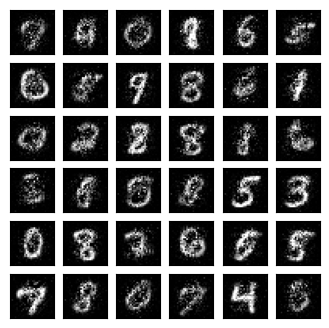

In [ ]:
normalizing_flow = NICE().to(device)
logistic_distribution = StandardLogisticDistribution(device=device)
x = torch.randn(10, 28 * 28, device=device)

optimizer = torch.optim.Adam(normalizing_flow.parameters(), lr=0.0002, weight_decay=0.9)
dataloader = DataLoader(trainX, batch_size=32, shuffle=True)

training_loss_bg = training(normalizing_flow, optimizer, dataloader, logistic_distribution, epochs=15,
                         device=device)

plot_res()

In [ ]:
28 * 28 // 2

392

###Summary

In [ ]:
y_values = {
    'hd_700': training_loss_hd_700,
    'hd_1300': training_loss_hd_1300,
    'base': training_loss_base,
    'small': training_loss_sm,
    'big': training_loss_bg,

}
df = pd.DataFrame(y_values)

fig = px.line(df, labels={'value': 'Loss', 'index': 'Epoch'},
              title='Different Architectures')

fig.show()

#ConvFlow

In [ ]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST

transform = transforms.Compose([transforms.ToTensor()])
train_dataset = MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [ ]:
class ConvFlow(nn.Module):
    def __init__(self, data_dim=28 * 28, hidden_dim=32):
        super(ConvFlow, self).__init__()

        self.conv_layers = nn.ModuleList([
            nn.Conv2d(1, hidden_dim, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        ])

        self.flatten = nn.Flatten()

        # Poprawione rozmiary warstw Fully Connected
        self.fc_layers = nn.ModuleList([
            nn.Linear(hidden_dim * 28 * 28, hidden_dim * 14 * 14),
            nn.Linear(hidden_dim * 14 * 14, data_dim),
        ])

        self.s = torch.nn.Parameter(torch.randn(data_dim))

    def forward(self, x):
        x = x.clone()  # Usunięto .unsqueeze(1)

        for layer in self.conv_layers:
            x = layer(x)

        x = self.flatten(x)

        for layer in self.fc_layers:
            x = layer(x)

        z = torch.exp(self.s) * x
        log_jacobian = torch.sum(self.s)
        return z, log_jacobian

    def invert(self, z):
        x = z.clone() / torch.exp(self.s)
        print("Input Size to Invert:", z.size())


        # Warstwy gęste
        print(reversed(self.fc_layers))
        for layer in reversed(self.fc_layers):
            x = layer(x)
            print(x.shape)

        x = x.view(x.size(0), 1, int(np.sqrt(x.size(1))), int(np.sqrt(x.size(1))))
        print("FC Inverted Output Size:", x.size())

        # Odwrotne operacje dla konwolucji
        for layer in reversed(self.conv_layers):
            if isinstance(layer, nn.Conv2d):
                x = torch.nn.functional.interpolate(x, scale_factor=2)
            x = layer(x)

        print("Conv Inverted Output Size:", x.size())

        return x.squeeze(1)

In [ ]:
def training_convflow(convflow, optimizer, dataloader, distribution, epochs=15, device='cpu'):
    training_loss = []
    for epoch in tqdm(range(epochs)):
        loss_list = []
        for batch, _ in dataloader:
            batch = batch.to(device)
            z, log_jacobian = convflow(batch)
            log_likelihood = distribution.log_pdf(z) + log_jacobian
            loss = -log_likelihood.sum()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_list.append(loss.item())
        training_loss.append(loss.item())

        print(f"Epoch [{epoch+1}/{epochs}], avg_loss: {np.mean(loss_list):.4f}")

    return training_loss


def plot_res_convflow(convflow, logistic_distribution, nb_data=6, device='cpu'):
    fig, axs = plt.subplots(nb_data, nb_data, figsize=(4, 4))
    for i in range(nb_data):
        for j in range(nb_data):
            x = convflow.invert(logistic_distribution.sample().unsqueeze(0).to(device)).data.cpu().numpy()
            axs[i, j].imshow(x.reshape(28, 28).clip(0, 1), cmap='gray')
            axs[i, j].set_xticks([])
            axs[i, j].set_yticks([])
    plt.show()

In [ ]:
x.shape

torch.Size([10, 784])

In [ ]:
# Inicjalizacja modelu ConvFlow, rozkładu logistycznego, danych i optymalizatora
convflow = ConvFlow().to(device)
logistic_distribution = StandardLogisticDistribution(device=device)
optimizer_convflow = torch.optim.Adam(convflow.parameters(), lr=0.0002, weight_decay=0.9)

# Trening ConvFlow
training_loss_convflow = training_convflow(convflow, optimizer_convflow, train_loader, logistic_distribution,
                                           epochs=15, device=device)

In [ ]:
convflow = ConvFlow().to(device)

In [ ]:
# Wygenerowanie i wyświetlenie przykładowych danych
plot_res_convflow(convflow, logistic_distribution, device=device)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Generowanie danych
num_samples = 1000
generated_data, _ = convflow.forward(torch.randn(num_samples, 28*28))

# Odwrotne przekształcenie
reconstructed_data = convflow.invert(generated_data)

# Redukcja wymiarowości za pomocą PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(reconstructed_data.detach().numpy())

# Klastrowanie
kmeans = KMeans(n_clusters=3)  # Dla przykładu, trzy klastry
labels = kmeans.fit_predict(reduced_data)

# Rysowanie klastrów
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap='viridis')
plt.title('Klastrowanie wygenerowanych danych')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


ConvFlow(
  (conv_layers): ModuleList(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc_layers): ModuleList(
    (0): Linear(in_features=12544, out_features=6272, bias=True)
    (1): Linear(in_features=6272, out_features=392, bias=True)
  )
)

#MAF

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MAF(nn.Module):
    def __init__(self, data_dim=28 * 28, hidden_dim=1000):
        super(MAF, self).__init__()

        self.m = nn.ModuleList([nn.Sequential(
            nn.Linear(data_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, data_dim), ) for _ in range(4)])

    def forward(self, x):
        z, log_jacobian = x.clone(), torch.zeros(x.shape[0], device=x.device)
        for i in range(len(self.m)):
            m_i = self.m[i](z)
            z_i = z * (1 - m_i.sigmoid()) + m_i.sigmoid() * (1 - z)
            log_jacobian += F.softplus(m_i).sum(dim=1)
            z = z_i
        return z, log_jacobian

    def invert(self, z):
        x = z.clone()
        for i in reversed(range(len(self.m))):
            m_i = self.m[i](x)
            x_i = x * (1 - m_i.sigmoid()) + m_i.sigmoid() * (1 - x)
            x = x_i
        return x


In [ ]:
def plot_res_maf(logistic_distribution, nb_data=6, device='cpu'):
    fig, axs = plt.subplots(nb_data, nb_data, figsize=(6, 6))
    for i in range(nb_data):
        for j in range(nb_data):
            x = maf_model.invert(logistic_distribution.sample().unsqueeze(0).to(device)).data.cpu().numpy()
            axs[i, j].imshow(x.reshape(28, 28).clip(0, 1), cmap='gray')
            axs[i, j].set_xticks([])
            axs[i, j].set_yticks([])
    plt.show()

In [ ]:
from torch.utils.data import DataLoader

transform = transforms.Compose([transforms.ToTensor()])
train_dataset = MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [ ]:
data_dim = 28 * 28
hidden_dim = 1000
device = 'cuda' if torch.cuda.is_available() else 'cpu'

maf_model = MAF(data_dim=data_dim, hidden_dim=hidden_dim).to(device)

optimizer = torch.optim.Adam(maf_model.parameters(), lr=0.001, weight_decay=0.9)

epochs = 20

In [ ]:
training_loss_maf = []
for epoch in tqdm(range(epochs)):
    loss_list = []
    for batch in train_loader:
        batch = batch[0].view(batch[0].size(0), -1).to(device)  # Dostosuj dane do modelu
        optimizer.zero_grad()
        z, log_jacobian = maf_model(batch)
        loss = -log_jacobian.mean()
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())

    training_loss_maf.append(loss.item())
    print(f"Epoch [{epoch+1}/{epochs}], avg_loss: {np.mean(loss_list):.4f}")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/20], avg_loss: -473687140180098254110720.0000
Epoch [2/20], avg_loss: -35702830702162422571991040.0000
Epoch [3/20], avg_loss: -254157971080512824791793664.0000
Epoch [4/20], avg_loss: -467824937429537751050485760.0000
Epoch [5/20], avg_loss: -601625554317042478202486784.0000
Epoch [6/20], avg_loss: -688846492207139692377800704.0000
Epoch [7/20], avg_loss: -780397623385730303538495488.0000
Epoch [8/20], avg_loss: -874196369889680577951432704.0000
Epoch [9/20], avg_loss: -957418837124873688818122752.0000
Epoch [10/20], avg_loss: -1024006250223143030056026112.0000
Epoch [11/20], avg_loss: -1066768139061994691061874688.0000
Epoch [12/20], avg_loss: -1105040619652529070675066880.0000
Epoch [13/20], avg_loss: -1140888131053071245114343424.0000
Epoch [14/20], avg_loss: -1175451730884972099351347200.0000
Epoch [15/20], avg_loss: -1209108332822056515603005440.0000
Epoch [16/20], avg_loss: -1242153671602245103557541888.0000
Epoch [17/20], avg_loss: -1275027182788471778367766528.0000
Ep

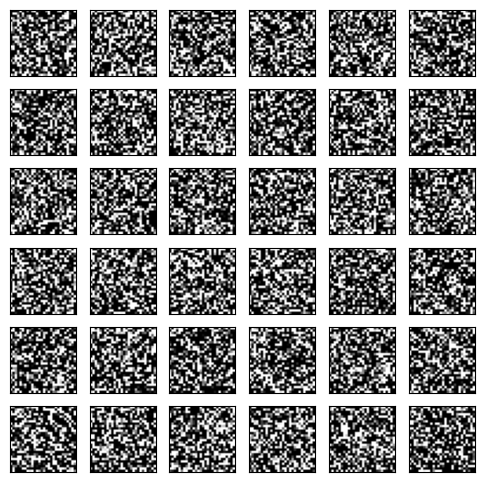

In [ ]:
logistic_distribution = StandardLogisticDistribution(device=device)

plot_res_maf(logistic_distribution, device=device)

In [ ]:
!pip install normflows

In [ ]:
import normflows as nf

In [ ]:
model = nf.NormalizingFlowVAE()

TypeError: ignored